# Manipulação de PDF

Passo a passo:

    Abrir o PDF
    Processar o texto em Chunks
    Construir um Vector Database de Embeddings                            
    Construir o RAG que usa um Vector Database para encontrar os Chunks corretos

Thanks to [Daniel Bourke](https://www.youtube.com/watch?v=qN_2fnOPY-M)

In [ ]:
import os
import requests

# Define o caminho do arquivo PDF
basedir = os.getcwd()
pdf_path = os.path.join(basedir, "..", "Webscraping", "Files", "PDF", "Livro", "LIVRO 35 ANOS.pdf")
pdf_path = os.path.normpath(pdf_path)

print(f"{pdf_path}")

In [ ]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str: 
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # Potentially more text formatting functions can go here
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = [] 
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 4,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_setence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, # 1 token = ~4 characters
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

In [ ]:
import random

random.sample(pages_and_texts, k=3)

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

In [ ]:
df.describe().round(2)

In [ ]:
from spacy.lang.en import English

nlp = English()

# Adiciona o componente de sentencização ao pipeline
nlp.add_pipe("sentencizer")

# Carrega o texto de exemplo
doc = nlp("This is a sentence. This another sentence. I like elephants.")
assert len(list(doc.sents)) == 3

list(doc.sents)

In [ ]:
pages_and_texts[50]

In [ ]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the default type is a spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

In [ ]:
random.sample(pages_and_texts, k=1)

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# e.g. [20] -> [10, 10] or [25] -> [10, 10, 5]
def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

In [ ]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

In [ ]:
random.sample(pages_and_texts, k=1)

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts): 
    for sentence_chunk in item["sentence_chunks"]: 
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" => ". A" (will work for any captial letter)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars

        pages_and_chunks.append(chunk_dict) 

len(pages_and_chunks)

In [ ]:
random.sample(pages_and_chunks, k=1)

In [ ]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

In [ ]:
df.head()

In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

In [ ]:
# Filter our DataFrame for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

In [ ]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

In [ ]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")

# Create a list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list.",
             "I like horses!"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

In [ ]:
embeddings[0].shape

In [ ]:
embedding = embedding_model.encode("My favourite animal is the cow!")
embedding

In [ ]:
%%time

embedding_model.to("cpu")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

In [ ]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[20]

In [ ]:
len(text_chunks)

In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=16, # you can experiment to find which batch size leads to best results
                                               convert_to_tensor=True)
text_chunk_embeddings                        

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
# Import saved file and view 
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

If your embedding database is really large (e.g. over 100k-1M samples) you might want to look into using a vector database for storage: https://en.wikipedia.org/wiki/Vector_database

In [ ]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert our embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embedding_df

In [ ]:
embeddings.shape

In [ ]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

In [ ]:
# 1. Define the query
query = "Diretor geral do campus"
print(f"Query: {query}")

# 2. Embed the query
# Note: it's import to embed you query with the same model you embedding your passages
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# 3. Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer() 

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product 

In [ ]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer() 

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

In [ ]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [ ]:
query = "Diretor geral do campus"
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

In [ ]:
import fitz # pymupdf library

doc = fitz.open(pdf_path)
page = doc.load_page(79 + 4) # note: page numbers of our PDF start 41+

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Save image (optional)
# img.save("output_filename.png")
doc.close()

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show() 

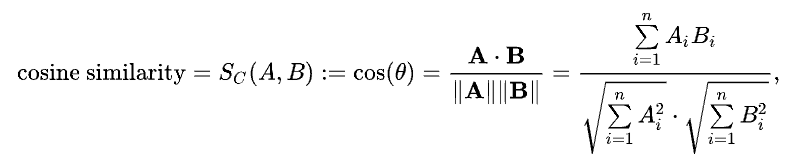

In [ ]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# torch.linalg.vector_norm
# cosine similarity consome mais processamento, para dados normalizados, use dot product.


# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))


In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Finds relevant passages given a query and prints them out along with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [ ]:
query="Diretores gerais do campus"
# retrieve_relevant_resources(query=query, embeddings=embeddings) 
print_top_results_and_scores(query=query, embeddings=embeddings)

In [ ]:
# Get GPU available memory
import torch

print(torch.cuda.is_available())  # Deve retornar True
print(torch.cuda.get_device_name(0))  # Nome da GPU
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
    model_id = "meta-llama/Llama-3.2-1B"
    use_quantization_config = False 
    print("Loading compatible model instead.")

elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

In [ ]:
# Ollama connection example
# Note: this is a local connection to the Ollama API, you can also use the Ollama CLI


# import requests # pip install requests
# import ollama # pip install ollama

# # Configuração do Ollama
# OLLAMA_API_URL = "http://localhost:11434"  # URL da API local do Ollama
# model_name = "llama3.2:1b"  # Substitua pelo nome correto do modelo no Ollama

# prompt = "Why is the sky blue?"
# response = ollama.chat(model=model_name, messages=[{'role': 'user', 'content': prompt}])
# print(response['message']['content'])

In [ ]:
from huggingface_hub import login # pip install --upgrade huggingface_hub
from .env import KEY

# Substitua 'seu_token' pelo token gerado
login(token=KEY)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create a quantization config
# Note: requires !pip install bitsandbytes accelerate
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: flash attention 2 = faster attention mechanism
# Flash Attention 2 requires a GPU with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper and above): https://developer.nvidia.com/cuda-gpus 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = "sdpa" # scaled dot product attention
print(f"Using attention implementation: {attn_implementation}") 

# 2. Pick a model we'd like to use
# model_id = "google/gemma-7b-it"
model_id = "meta-llama/Llama-3.2-1B"

# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model 
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use as much memory as we can
                                                 attn_implementation=attn_implementation) #  if using flash attention 2 else None)

if not use_quantization_config:
    llm_model.to("cuda")

In [ ]:
llm_model

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3) 

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2), 
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

In [ ]:
# exemplo do Gemmma
# input_text = "Quem foram os diretores gerais do campus medianeira?"
# print(f"Input text:\n{input_text}")

# # Create prompt template for instruction-tuned model
# dialogue_template = [
#     {"role": "user",
#      "content": input_text}
# ]

# # Apply the chat template
# prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
#                                        tokenize=False,
#                                        add_generation_prompt=True)
# print(f"\nPrompt (formatted):\n{prompt}")

In [ ]:
# Exemplo llama 3.2
# Certifique-se de que o modelo e o tokenizador já estão carregados
# Exemplo:
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
# llm_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")

input_text = "O que é a UTFPR?"
print(f"Input text:\n{input_text}")

# Tokenize o texto de entrada
inputs = tokenizer(input_text, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# Gere a resposta usando o modelo
outputs = llm_model.generate(
    **inputs,
    max_length=200,  # Limite de tokens na resposta
    temperature=0.7,  # Controla a aleatoriedade da geração
    top_p=0.9,        # Nucleus sampling
    repetition_penalty=1.2  # Penaliza repetições
)

# Decodifique a saída para texto
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"\nResposta do modelo:\n{response}")

In [ ]:
tokenizer

In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to the GPU
input_ids = tokenizer(response,
                      return_tensors="pt").to("cuda")

# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

In [ ]:
# Manually created question list
manual_questions = [
    "Quem foi o primeiro diretor geral?"
]

query_list = manual_questions
query_list

In [ ]:
import random

query = random.choice(query_list)
print(f"Query: {query}\n")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

In [ ]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
    # Formata os itens de contexto
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Define o prompt base com exemplos
    base_prompt = f"""Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: O que é o Livro dos 35 Anos da UTFPR?
Answer: O Livro dos 35 Anos da UTFPR é uma obra que celebra a trajetória da Universidade Tecnológica Federal do Paraná (UTFPR) ao longo de seus 35 anos de história. O livro reúne relatos, fotos e informações sobre a evolução da instituição, suas conquistas e desafios enfrentados desde sua fundação. É um registro importante para a comunidade acadêmica e para todos que fazem parte da história da UTFPR.

Example 2:
Query: Para que serve o Livro dos 35 anos da UTFPR?
Answer: O Livro dos 35 Anos da UTFPR serve como um registro histórico e comemorativo da trajetória da Universidade Tecnológica Federal do Paraná (UTFPR) ao longo de seus 35 anos. Ele documenta as conquistas, desafios e evolução da instituição, proporcionando uma visão abrangente de sua importância na educação e na pesquisa no Brasil. Além disso, o livro é uma forma de celebrar a comunidade acadêmica e os esforços coletivos que contribuíram para o crescimento da UTFPR.

Example 3:
Query: Quem é voce e o que voce faz?
Answer: Eu sou um modelo de linguagem projetado para entender e gerar texto em linguagem natural. Minha principal função é ajudar os usuários a encontrar informações, responder perguntas e fornecer assistência em uma variedade de tópicos relacionados à instituição UTFPR. Posso ajudar com pesquisas, redação, aprendizado de idiomas e muito mais. Meu objetivo é facilitar a comunicação e fornecer respostas úteis e precisas.

Now use the following context items to answer the user query:
{context}

User query: {query}
Answer:"""

    return base_prompt


# Exemplo de uso
query = random.choice(query_list)  # Escolhe uma query aleatória
print(f"Query: {query}")

# Recupera os recursos relevantes
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

# Cria uma lista de itens de contexto
context_items = [pages_and_chunks[i] for i in indices]

# Formata o prompt
prompt = prompt_formatter(query=query, context_items=context_items)
print(f"Prompt formatado:\n{prompt}")

# Tokeniza o prompt
inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

# Gera a resposta usando o modelo
outputs = llm_model.generate(
    **inputs,
    max_length=2000,  # Limite de tokens na resposta
    temperature=0.7,  # Controla a aleatoriedade da geração
    top_p=0.9,        # Nucleus sampling
    repetition_penalty=1.2  # Penaliza repetições
)

# Decodifica a saída para texto
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"\nResposta do modelo:\n{response}")

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # from 0 to 1 and the lower the value, the more deterministic the text, the higher the value, the more creative
                             do_sample=True, # whether or not to use sampling, https://huyenchip.com/2024/01/16/sampling.html
                             max_new_tokens=256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}")
print(f"RAG answer:\m{output_text.replace(prompt, '')}")

In [ ]:
def ask(query: str,
        temperature: float=0.7,
        max_new_tokens:int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # RETRIEVAL
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices] 

    # Add score to context item
    for i, item in enumerate(context_items): 
        item["score"] = scores[i].cpu()

    # AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # GENERATION
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, context_items

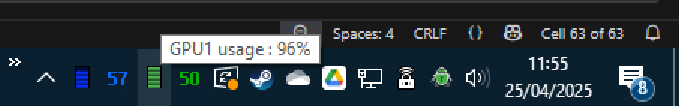

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")
ask(query=query,
    temperature=0.2,
    return_answer_only=True)